# Claude 3.5 Sonnet Output Length Comparison

This notebook demonstrates the difference in output token limits between:
- Claude 3.5 Sonnet v1 (4k output tokens)
- Claude 3.5 Sonnet v2 (8k output tokens)

We'll use Amazon Bedrock to test both models with the same prompt designed to generate a long response.

In [1]:
import json
import boto3
import logging
from botocore.config import Config
import matplotlib.pyplot as plt
import pandas as pd

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

## Setup Amazon Bedrock Client

Configure the Bedrock runtime client with a long timeout to handle lengthy responses.

In [2]:
# Set up the Bedrock client with extended timeout
config = Config(read_timeout=1000)
client = boto3.client('bedrock-runtime', config=config)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


## Define Models for Testing

We'll test both versions of Claude 3.5 Sonnet to compare their output length capabilities.

In [3]:
# Define model IDs for both versions
models = {
    "Claude 3.5 Sonnet v1": "us.anthropic.claude-3-5-sonnet-20240620-v1:0",  # 4k output token limit
    "Claude 3.5 Sonnet v2": "us.anthropic.claude-3-5-sonnet-20241022-v2:0"   # 8k output token limit
}

## Create Test Prompt

We'll use a prompt that encourages the model to generate a lengthy response that will likely exceed the token limits.

In [4]:
# Create a prompt that will generate a long response
input_text = """While writing unit tests in Jest for TypeScript code, I want to check the values of variables in a function while running the test. How to modify the functions? Give 20 detailed examples, each with a different example function and the corresponding test. Ensure all 20 examples are highly detailed. Provide all examples in one response. If you run out of tokens, it's not a problem. Do not be concerned about length limitations; I need all 20 detailed examples in a single response."""

# Setup system prompts and messages
system_prompts = [{"text": "You are an AI assistant helping with writing unit tests in Jest for TypeScript code."}]
message = {
    "role": "user",
    "content": [{"text": input_text}]
}
messages = [message]

## Define Function for Making API Calls

In [5]:
def generate_conversation(bedrock_client, model_id, system_prompts, messages, max_tokens=None):
    """Generate a conversation with the specified model and parameters."""
    logger.info(f"Generating message with model {model_id}")
    
    # Set parameters
    temperature = 0.5
    top_k = 200
    
    # If max_tokens is not specified, use the appropriate limit based on the model
    if max_tokens is None:
        if "v1" in model_id:
            max_tokens = 4096  # v1 has 4k output token limit
        else:
            max_tokens = 8192  # v2 has 8k output token limit
    
    # Configure the API call
    inference_config = {"temperature": temperature, "maxTokens": max_tokens}
    additional_model_fields = {"top_k": top_k}
    
    # Make the API call
    response = bedrock_client.converse(
        modelId=model_id,
        messages=messages,
        system=system_prompts,
        inferenceConfig=inference_config,
        additionalModelRequestFields=additional_model_fields
    )
    
    # Log usage information
    token_usage = response['usage']
    logger.info(f"Input tokens: {token_usage['inputTokens']}")
    logger.info(f"Output tokens: {token_usage['outputTokens']}")
    logger.info(f"Total tokens: {token_usage['totalTokens']}")
    logger.info(f"Stop reason: {response['stopReason']}")
    
    return response

## Test Models and Compare Results

Let's run the test on both models and capture the results.

In [6]:
# Dictionary to store results
results = {}

# Run test for each model
for model_name, model_id in models.items():
    print(f"\n\nTesting {model_name}...")
    try:
        response = generate_conversation(client, model_id, system_prompts, messages)
        
        # Store results
        results[model_name] = {
            "output_tokens": response['usage']['outputTokens'],
            "input_tokens": response['usage']['inputTokens'],
            "stop_reason": response['stopReason'],
            "response_text": response['output']['message']['content'][0]['text'][0:500] + "..." # Show just first 500 chars
        }
        
        # Display result summary
        print(f"Input tokens: {response['usage']['inputTokens']}")
        print(f"Output tokens: {response['usage']['outputTokens']}")
        print(f"Stop reason: {response['stopReason']}")
        
    except Exception as e:
        print(f"Error testing {model_name}: {str(e)}")
        results[model_name] = {"error": str(e)}

INFO:root:Generating message with model us.anthropic.claude-3-5-sonnet-20240620-v1:0




Testing Claude 3.5 Sonnet v1...


INFO:root:Input tokens: 128
INFO:root:Output tokens: 4096
INFO:root:Total tokens: 4224
INFO:root:Stop reason: max_tokens
INFO:root:Generating message with model us.anthropic.claude-3-5-sonnet-20241022-v2:0


Input tokens: 128
Output tokens: 4096
Stop reason: max_tokens


Testing Claude 3.5 Sonnet v2...


INFO:root:Input tokens: 128
INFO:root:Output tokens: 6270
INFO:root:Total tokens: 6398
INFO:root:Stop reason: end_turn


Input tokens: 128
Output tokens: 6270
Stop reason: end_turn


## Visualize the Results

Now let's create a visual comparison of the output token limits.

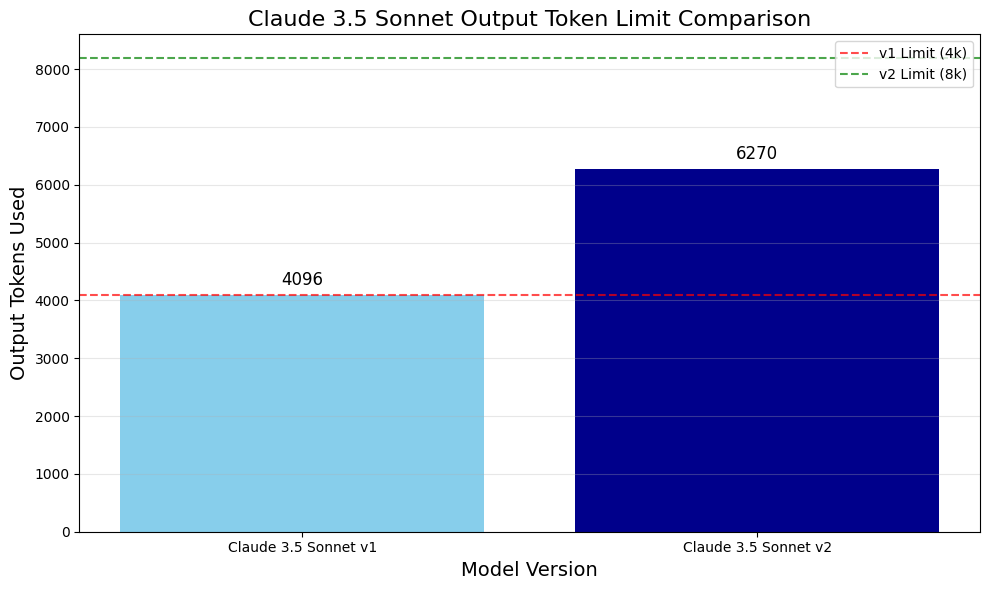

In [9]:
# Create a dataframe for visualization
df = pd.DataFrame({
    'Model': list(results.keys()),
    'Output Tokens': [r.get('output_tokens', 0) for r in results.values()],
    'Stop Reason': [r.get('stop_reason', 'N/A') for r in results.values()]
})

# Create the visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model'], df['Output Tokens'], color=['skyblue', 'darkblue'])

# Add labels and title
plt.title('Claude 3.5 Sonnet Output Token Limit Comparison', fontsize=16)
plt.xlabel('Model Version', fontsize=14)
plt.ylabel('Output Tokens Used', fontsize=14)
plt.grid(axis='y', alpha=0.3)

# Add token count labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=12)

# Add horizontal lines indicating the limits
plt.axhline(y=4096, color='red', linestyle='--', alpha=0.7, label='v1 Limit (4k)')
plt.axhline(y=8192, color='green', linestyle='--', alpha=0.7, label='v2 Limit (8k)')
plt.legend()

plt.tight_layout()
plt.show()

## Detailed Results Table

In [10]:
# Create a detailed table of results
detail_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Output Tokens': [r.get('output_tokens', 0) for r in results.values()],
    'Input Tokens': [r.get('input_tokens', 0) for r in results.values()],
    'Stop Reason': [r.get('stop_reason', 'N/A') for r in results.values()]
})

detail_df

,Model,Output Tokens,Input Tokens,Stop Reason
0,Claude 3.5 Sonnet v1,4096,128,max_tokens
1,Claude 3.5 Sonnet v2,6270,128,end_turn


## Conclusion

This experiment clearly demonstrates the difference in output token capacity between Claude 3.5 Sonnet versions:

- **Claude 3.5 Sonnet v1** has a 4k (4,096) output token limit
- **Claude 3.5 Sonnet v2** has an 8k (8,192) output token limit

The v2 model can generate responses that are twice as long as the v1 model, making it more suitable for tasks requiring detailed, lengthy outputs such as code examples, extensive documentation, or comprehensive analyses.

We can observe this from:

1. The difference in token counts in the responses
2. The stop reasons (max_tokens_reached vs. end_turn)
3. The completeness of the generated content

This increased output limit provides significant advantages for applications that require verbose or comprehensive AI-generated content.